In [51]:
import numpy as np
import pandas as pd
import itertools

# Modelling Helpers :
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning Libraries
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import  LearningRateScheduler
from keras.utils import to_categorical

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns


train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')
df = train.copy()
df_test = test.copy()

print(df.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

In [28]:
print('Train: ', df.shape)
print('Test: ', df_test.shape)

Train:  (60000, 785)
Test:  (10000, 785)


In [29]:
df.label.unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

In [30]:
df.isnull().any().sum()

0

In [31]:
df_test.isnull().any().sum()

0

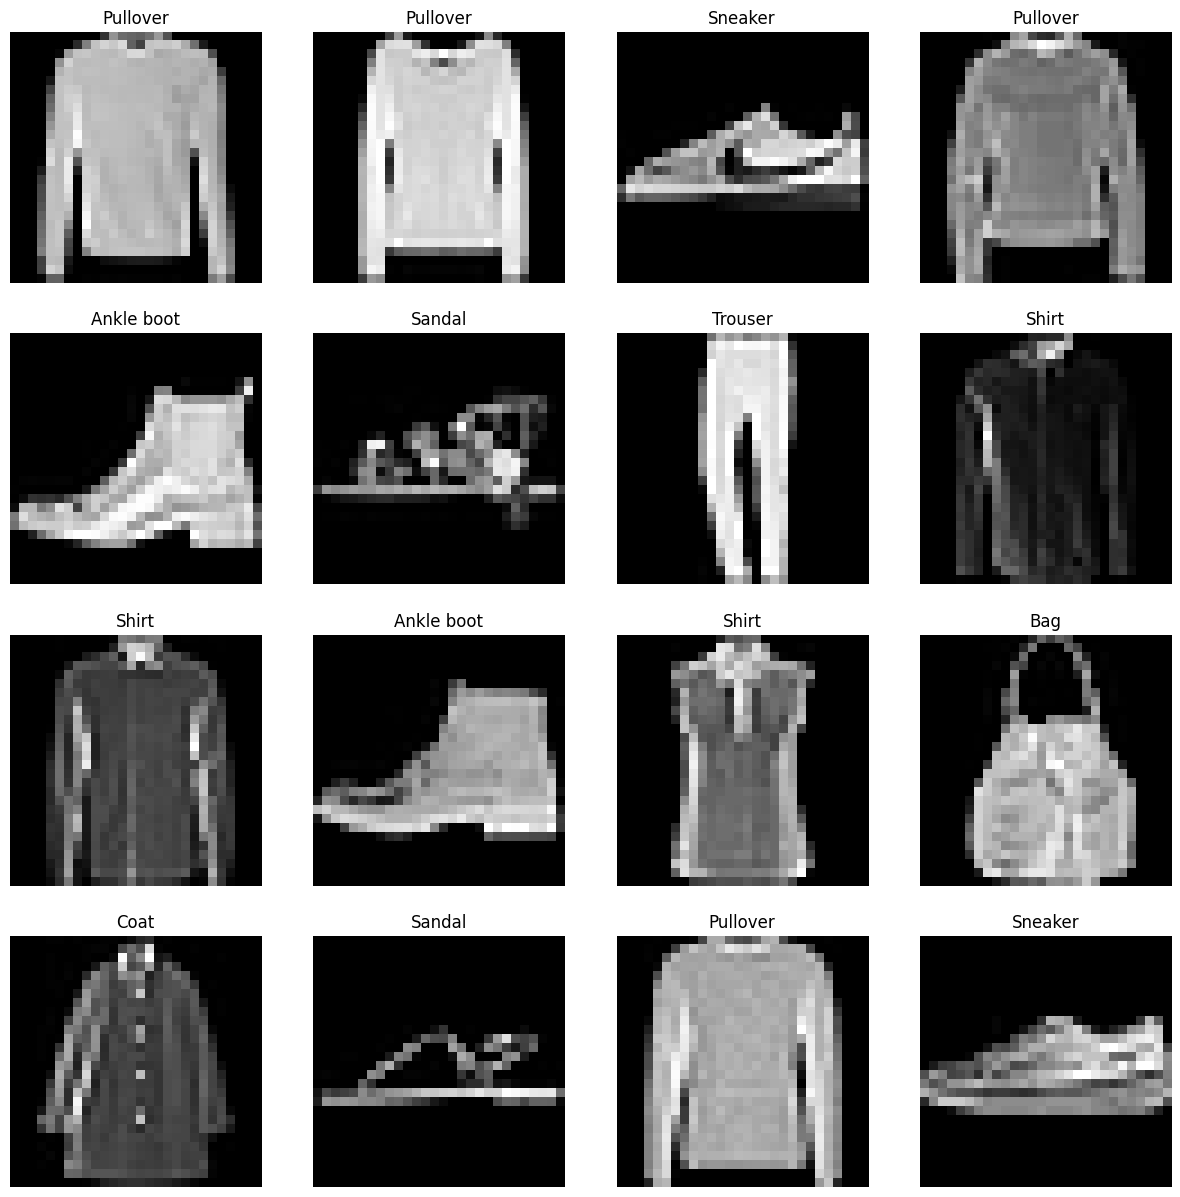

In [32]:
# Mapping Classes
clothing = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

fig, axes = plt.subplots(4, 4, figsize = (15,15))
for row in axes:
    for axe in row:
        index = np.random.randint(60000)
        img = df.drop('label', axis=1).values[index].reshape(28,28)
        cloths = df['label'][index]
        axe.imshow(img, cmap='gray')
        axe.set_title(clothing[cloths])
        axe.set_axis_off()

In [33]:

df['label'].value_counts()

2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: label, dtype: int64

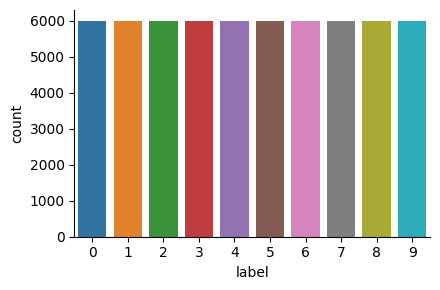

In [34]:
sns.catplot(x='label', data=df, kind='count', height=3, aspect= 1.5)

In [37]:
seed = 66
np.random.seed(seed)

X = train.iloc[:,1:]
Y = train.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)

x_train = x_train.values.reshape((-1, 28, 28, 1))
x_test = x_test.values.reshape((-1, 28, 28, 1))

df_test.drop('label', axis=1, inplace=True)
df_test = df_test.values.reshape((-1, 28, 28, 1))

x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
df_test = df_test.astype("float32")/255

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [38]:
print(y_train.shape)
print(y_test.shape)

(54000, 10)
(6000, 10)


In [82]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))


In [83]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [84]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 1152)             

In [85]:
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [86]:
datagen = ImageDataGenerator(
        rotation_range = 8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
        width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
        vertical_flip=True)  # randomly flip images

In [87]:
datagen.fit(x_train)

In [88]:
batch_size = 128
epochs = 40

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (x_test, y_test), verbose=2, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks = [reduce_lr])

Epoch 1/40


C:\Users\LEGION\AppData\Local\Temp\ipykernel_7464\1093342589.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs,


421/421 - 14s - loss: 0.7699 - accuracy: 0.7145 - val_loss: 0.5632 - val_accuracy: 0.7602 - lr: 0.0010 - 14s/epoch - 34ms/step
Epoch 2/40
421/421 - 14s - loss: 0.5581 - accuracy: 0.7913 - val_loss: 0.4476 - val_accuracy: 0.8318 - lr: 9.0000e-04 - 14s/epoch - 33ms/step
Epoch 3/40
421/421 - 13s - loss: 0.5012 - accuracy: 0.8147 - val_loss: 0.4016 - val_accuracy: 0.8500 - lr: 8.1000e-04 - 13s/epoch - 31ms/step
Epoch 4/40
421/421 - 13s - loss: 0.4548 - accuracy: 0.8307 - val_loss: 0.4024 - val_accuracy: 0.8505 - lr: 7.2900e-04 - 13s/epoch - 30ms/step
Epoch 5/40
421/421 - 13s - loss: 0.4317 - accuracy: 0.8390 - val_loss: 0.3767 - val_accuracy: 0.8620 - lr: 6.5610e-04 - 13s/epoch - 32ms/step
Epoch 6/40
421/421 - 14s - loss: 0.4121 - accuracy: 0.8461 - val_loss: 0.3462 - val_accuracy: 0.8712 - lr: 5.9049e-04 - 14s/epoch - 34ms/step
Epoch 7/40
421/421 - 13s - loss: 0.3926 - accuracy: 0.8527 - val_loss: 0.3414 - val_accuracy: 0.8737 - lr: 5.3144e-04 - 13s/epoch - 30ms/step
Epoch 8/40
421/421 - 

In [89]:
score = model.evaluate(x_test, y_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

188/188 [==============================] - 1s 5ms/step - loss: 0.2779 - accuracy: 0.9017
Loss: 0.2779
Accuracy: 0.9017


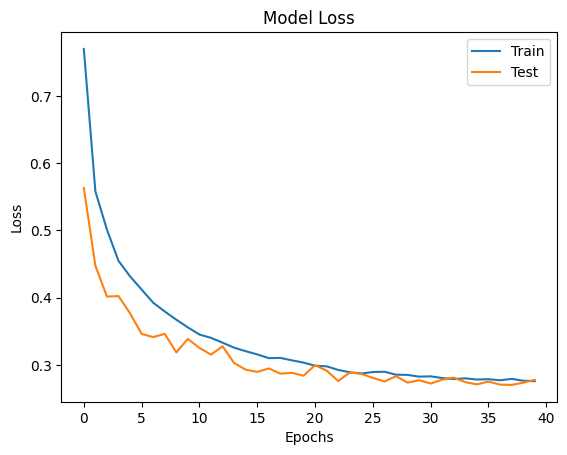

In [90]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

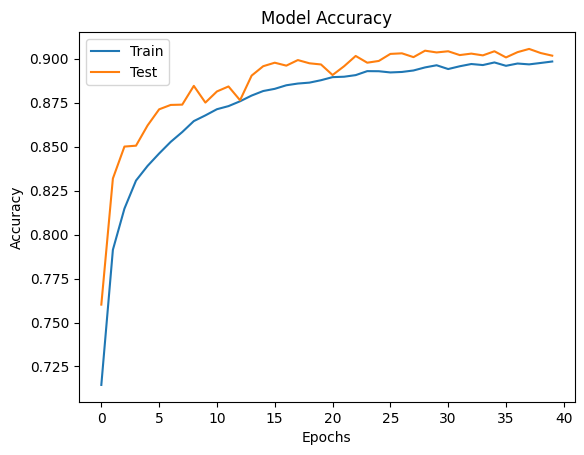

In [91]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

In [92]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

188/188 [==============================] - 0s 2ms/step


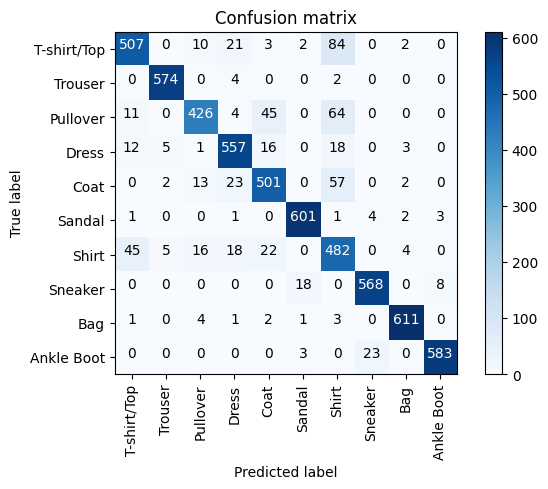

In [93]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

In [94]:

correct = []
for i in range(len(y_test)):
    if(Y_pred_classes[i] == Y_true[i]):
        correct.append(i)
    if(len(correct) == 4):
        break

Text(0.5, 1.0, 'Predicted Label : Pullover\nActual Label : Pullover')

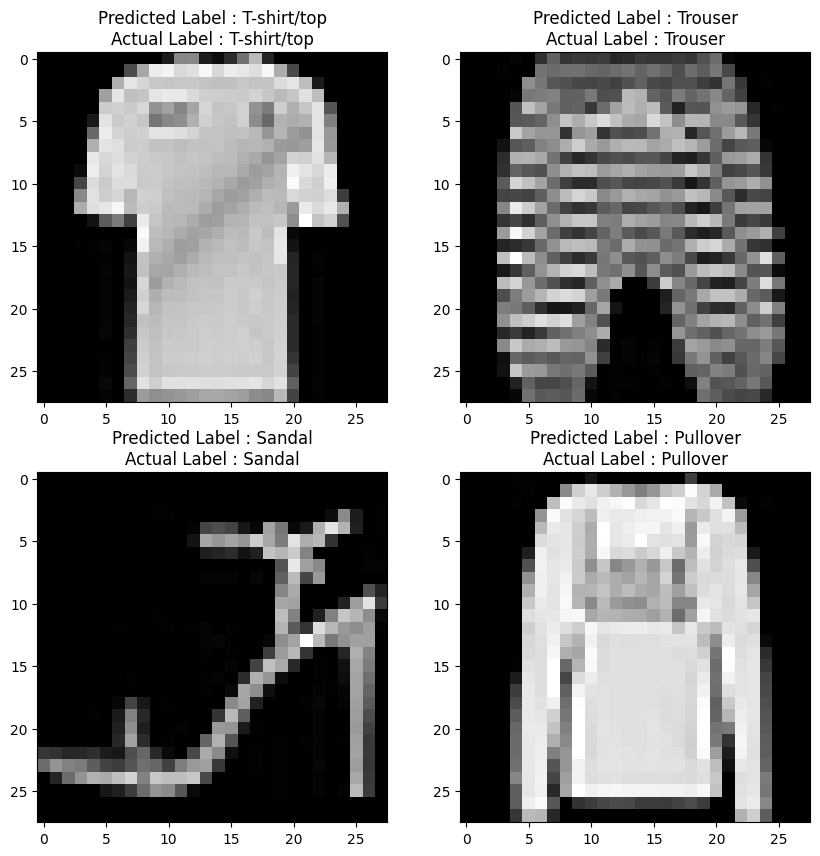

In [95]:
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.set_size_inches(10,10)
ax[0,0].imshow(x_test[correct[0]].reshape(28,28), cmap='gray')
ax[0,0].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[0]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[correct[0]]]))
ax[0,1].imshow(x_test[correct[1]].reshape(28,28), cmap='gray')
ax[0,1].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[1]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[correct[1]]]))
ax[1,0].imshow(x_test[correct[2]].reshape(28,28), cmap='gray')
ax[1,0].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[2]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[correct[2]]]))
ax[1,1].imshow(x_test[correct[3]].reshape(28,28), cmap='gray')
ax[1,1].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[3]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[correct[3]]]))

In [96]:
incorrect = []
for i in range(len(y_test)):
    if(not Y_pred_classes[i] == Y_true[i]):
        incorrect.append(i)
    if(len(incorrect) == 4):
        break

Text(0.5, 1.0, 'Predicted Label : Bag\nActual Label : Shirt')

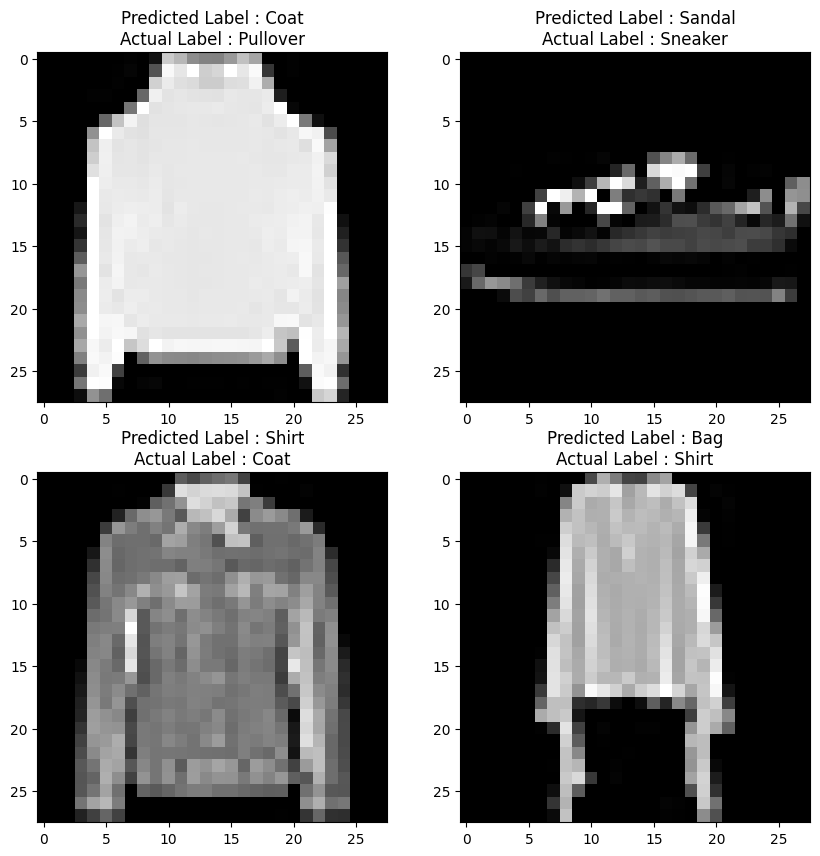

In [97]:
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.set_size_inches(10,10)
ax[0,0].imshow(x_test[incorrect[0]].reshape(28,28), cmap='gray')
ax[0,0].set_title("Predicted Label : " + str(clothing[Y_pred_classes[incorrect[0]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[incorrect[0]]]))
ax[0,1].imshow(x_test[incorrect[1]].reshape(28,28), cmap='gray')
ax[0,1].set_title("Predicted Label : " + str(clothing[Y_pred_classes[incorrect[1]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[incorrect[1]]]))
ax[1,0].imshow(x_test[incorrect[2]].reshape(28,28), cmap='gray')
ax[1,0].set_title("Predicted Label : " + str(clothing[Y_pred_classes[incorrect[2]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[incorrect[2]]]))
ax[1,1].imshow(x_test[incorrect[3]].reshape(28,28), cmap='gray')
ax[1,1].set_title("Predicted Label : " + str(clothing[Y_pred_classes[incorrect[3]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[incorrect[3]]]))

In [98]:
classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(classification_report(Y_true, Y_pred_classes, target_names = classes))

              precision    recall  f1-score   support

 T-shirt/Top       0.88      0.81      0.84       629
     Trouser       0.98      0.99      0.98       580
    Pullover       0.91      0.77      0.84       550
       Dress       0.89      0.91      0.90       612
        Coat       0.85      0.84      0.84       598
      Sandal       0.96      0.98      0.97       613
       Shirt       0.68      0.81      0.74       592
     Sneaker       0.95      0.96      0.96       594
         Bag       0.98      0.98      0.98       623
  Ankle Boot       0.98      0.96      0.97       609

    accuracy                           0.90      6000
   macro avg       0.91      0.90      0.90      6000
weighted avg       0.91      0.90      0.90      6000



In [99]:
X = x_test
Y = y_test

score = model.evaluate(X, Y)

print("Loss: {:.4f}".format(score[0]))
print("Accuracy: {:.4f}".format(score[1]))

188/188 [==============================] - 1s 5ms/step - loss: 0.2779 - accuracy: 0.9017
Loss: 0.2779
Accuracy: 0.9017


In [100]:
model.save('modelai.h5')